In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython import display
from math import *
import time
from PIL import Image

import copy

In [2]:
maze = 1*(np.array(Image.open("maze.png"))[:,:,0]>0)

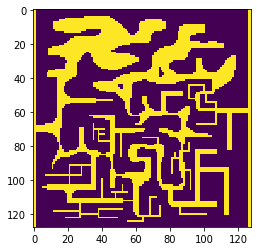

In [3]:
plt.imshow(maze, interpolation='nearest')

## MAP-Elites

In [4]:
def diminishingMean(x):
    z = np.sort(x)
    w = np.arange(x.shape[0])**4
    
    return np.sum(w*z)/np.sum(w)

def diversity(x):
    dist = np.sqrt(np.sum((x[np.newaxis,:,:]-x[:,np.newaxis,:])**2,axis=2))
    dist = dist + 1e9 * np.eye(dist.shape[0], dist.shape[1])
    
    return np.min(dist,axis=0).mean()

class MAPElites():
    def __init__(self, RESOLUTION = 16, NICHE_POP = 1, xmin=0, xmax=128, ymin=0, ymax=128):
        self.niches = [ [ [] for i in range(RESOLUTION) ] for j in range(RESOLUTION) ]
        self.NICHE_POP = NICHE_POP
        self.RESOLUTION = RESOLUTION
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
    
    def add(self, x, projection):
        z = projection(x)
            
        i = int(np.clip( self.RESOLUTION*(z[0]-self.xmin)/(self.xmax-self.xmin), 0, self.RESOLUTION-1))
        j = int(np.clip( self.RESOLUTION*(z[1]-self.ymin)/(self.ymax-self.ymin), 0, self.RESOLUTION-1))
        
        self.niches[i][j].append(x)
    
    def step(self, mutation, projection, fitness):
        pop = []
        for n in self.niches:
            for n2 in n:
                pop = pop + n2
        
        #w = 1+np.array([p[2]**2 for p in pop])
        #w = w/np.sum(w)
        
        for p in pop:
            #p = pop[np.random.choice(np.arange(len(pop)), p=w)]
            p2 = mutation(p)
            #p2[2] = 0
            z2 = projection(p2)
            f2 = fitness(p2)
            
            if f2>=0:
                i = int(np.clip( self.RESOLUTION*(z2[0]-self.xmin)/(self.xmax-self.xmin), 0, self.RESOLUTION-1))
                j = int(np.clip( self.RESOLUTION*(z2[1]-self.ymin)/(self.ymax-self.ymin), 0, self.RESOLUTION-1))

                n2 = self.niches[i][j]
                if len(n2)<self.NICHE_POP:
                    p[2] += 1
                    self.niches[i][j].append(p2)
                else:
                    k = np.random.randint(len(n2))
                    fits1 = np.array([fitness(n) for n in n2])
                    proj1 = np.array([projection(n) for n in n2])
                    
                    fits2 = fits1.copy()
                    fits2[k] = f2
                    
                    proj2 = proj1.copy()
                    proj2[k] = z2
                    
                    if diminishingMean(fits2) + 10*diversity(proj2) > diminishingMean(fits1) + 10*diversity(proj1):
                        p[2] += 1
                        self.niches[i][j][k] = p2

In [5]:
def mutate(p):
    return p + np.array([(2*np.random.rand()-1),(2*np.random.rand()-1),0])

def mutate2(p):
    return p + np.array([(2*np.random.rand()-1),(2*np.random.rand()-1)])

def projection(p):
    return p

def fitness(p):
    f = p[1]
    if p[0]<0 or p[1]<0 or p[0]>=maze.shape[0] or p[1]>=maze.shape[1]:
        f -= 100000
    else:
        if maze[int(p[0]), int(p[1])]<0.5:
            f -= 100000
    
    return f

In [157]:
pop = MAPElites(RESOLUTION=32, NICHE_POP=8)
pop.add(np.array([64,0,0]), projection)

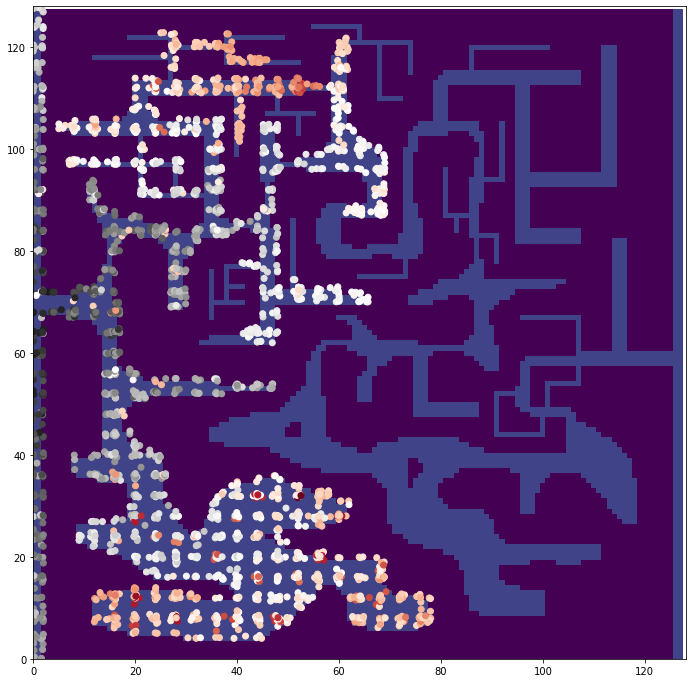

KeyboardInterrupt: 

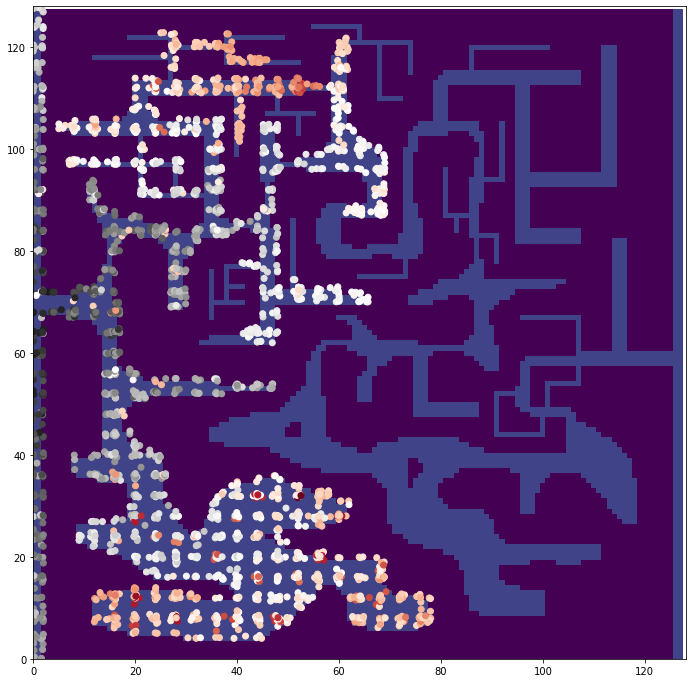

In [158]:
for step in range(1000):
    pop.step(mutate, projection, fitness)
    
    if step%10 == 0:
        allpop = []
        for n in pop.niches:
            for n2 in n:
                allpop = allpop + n2
        allpop = np.array(allpop)

        plt.clf()
        plt.imshow(maze, vmin=0,vmax=5)
        plt.scatter(allpop[:,1], allpop[:,0], c=allpop[:,2], cmap=plt.cm.RdGy_r)
        plt.xlim(0,128)
        plt.ylim(0,128)
        plt.gcf().set_size_inches((12,12))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)

## Spanning Population

In [6]:
def spanPopulation(N, population, fitness, steps=100):
    zs = np.array([s for s in population])
    dist = np.mean((zs[np.newaxis,:,:]-zs[:,np.newaxis,:])**2, axis=2)
    dist = dist + 1e9 * np.eye(dist.shape[0], dist.shape[1])        
    
    def evalDist(sp):
        subdist = dist[sp[:,np.newaxis], sp[np.newaxis,:]]        
        mindist = np.min(subdist,axis=0)
        return np.mean(mindist) + 0.01 * diminishingMean(np.array([fitness(population[i]) for i in sp]))
    
    if N>len(population):
        return population, 0
    
    subpop = np.random.permutation(len(population))[:N]
    score = evalDist(subpop)
    
    for i in range(steps):
        subpop2 = subpop.copy()
        for j in range(1):
            k = np.random.randint(N)
            subpop2[k] = -1
            
            l = np.random.randint(len(population))
            while l in subpop2:
                l = np.random.randint(len(population))
                
            subpop2[k] = l
        
        score2 = evalDist(subpop2)
        
        if score2>score:
            subpop = subpop2
            score = score2
    
    return [population[i] for i in subpop], score

In [7]:
population = [np.array([64,0]) for i in range(16)]

KeyboardInterrupt: 

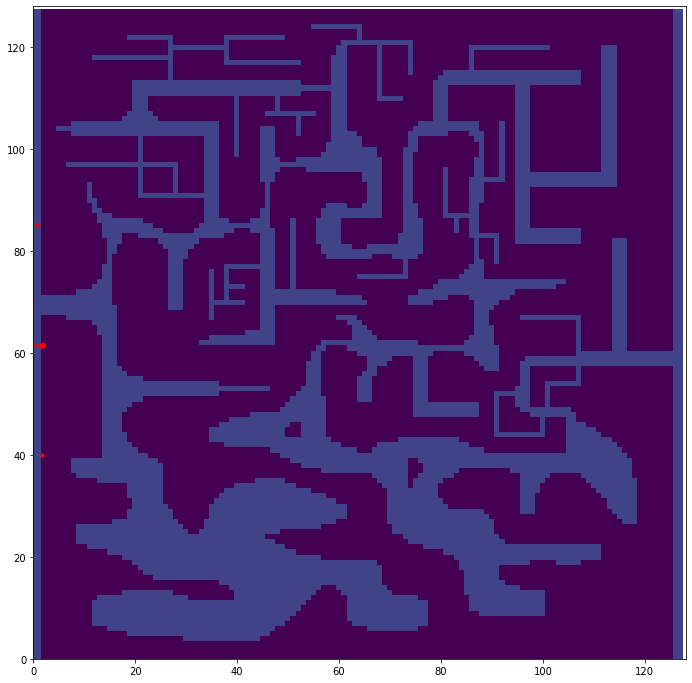

In [8]:
for step in range(1000):       
    zs = np.array([s for s in population])
    dist = np.mean((zs[np.newaxis,:,:]-zs[:,np.newaxis,:])**2, axis=2)
    dist = dist + 1e9 * np.eye(dist.shape[0], dist.shape[1])        

    mindist = np.min(dist, axis=0)
    rank = np.zeros(mindist.shape[0])
    arg = np.argsort(mindist)
    for i in range(mindist.shape[0]):
        rank[arg[i]] = i+1

    rank = rank
    rank = rank/np.sum(rank)
    N = len(population)

    for i in range(N):
        p = mutate2(population[np.random.choice(np.arange(rank.shape[0]), p=rank)].copy())
        if fitness(p)>=0:
            pdist = np.mean((p[np.newaxis,np.newaxis,:]-zs[:,np.newaxis,:])**2,axis=2)

            j = np.random.randint(len(population))
            sp1 = np.arange(len(population))
            sp2 = sp1.copy()
            sp2[j] = len(population)
            
            tdist = np.concatenate([dist, pdist], axis=1)
            pdist = pdist.transpose(1,0)
            pdist = np.concatenate([pdist, np.array([[1e9]])], axis=1)
            tdist = np.concatenate([tdist, pdist], axis=0)
            
            min1 = np.min(tdist[sp1[np.newaxis,:], sp1[:,np.newaxis]],axis=0).mean()
            min2 = np.min(tdist[sp2[np.newaxis,:], sp2[:,np.newaxis]],axis=0).mean()
            
            if min2>min1:
                population[j] = p
                dist = tdist[sp2[np.newaxis,:], sp2[:,np.newaxis]]
           # population.append(p)
            
    if step%10 == 0:
        plt.clf()
        plt.imshow(maze, vmin=0,vmax=5)
        plt.scatter(np.array(population)[:,1], np.array(population)[:,0], c='r', s=10)
        plt.xlim(0,128)
        plt.ylim(0,128)
        plt.gcf().set_size_inches((12,12))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)


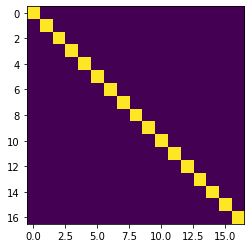

In [303]:
plt.imshow(tdist)

In [304]:
np.min(tdist,axis=0)

array([2.08825854e-03, 1.04512688e-03, 1.06155012e-03, 1.52366722e-03,
       1.64368829e-01, 1.88638104e+02, 1.46268506e-03, 1.87339114e-03,
       1.24377872e-03, 7.52900391e-04, 1.83420340e-03, 1.52366722e-03,
       3.27848878e+02, 7.44827453e-04, 7.44827453e-04, 7.52900391e-04,
       1.64368829e-01])

In [15]:
zs = np.array([s for s in population])
dist = np.mean((zs[np.newaxis,:,:]-zs[:,np.newaxis,:])**2, axis=2)
dist = dist + 1e9 * np.eye(dist.shape[0], dist.shape[1])        
N = 8
steps = 5000
def evalDist(sp):
    subdist = dist[sp[:,np.newaxis], sp[np.newaxis,:]]        
    mindist = np.min(subdist,axis=0)
    return np.mean(mindist) #+ 0.1 * diminishingMean(np.array([fitness(population[i]) for i in sp]))
        
subpop = np.arange(N)#np.random.permutation(len(population))[:N]
score = evalDist(subpop)

for i in range(steps):
    subpop2 = subpop.copy()
    for j in range(2):
        k = np.random.randint(N)
        subpop2[k] = -1

        l = np.random.randint(zs.shape[0])
        while l in subpop2:
            l = np.random.randint(zs.shape[0])

        subpop2[k] = l

    score2 = evalDist(subpop2)

    if score2>score:
        subpop = subpop2
        score = score2

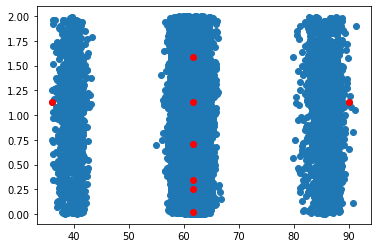

In [16]:
plt.scatter(zs[:,0], zs[:,1])
plt.scatter(zs[subpop,0], zs[subpop,1], c='r')
plt.show()

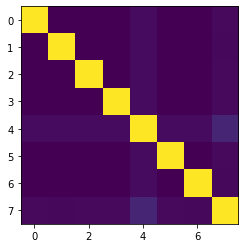

In [11]:
plt.imshow(dist[subpop[:,np.newaxis], subpop[np.newaxis,:]],vmin=0,vmax=10000)

In [12]:
while len(population)<16384:
    p = mutate2(population[np.random.randint(len(population))].copy())
    if fitness(p)>=0:
        population.append(p)

In [241]:
len(population)

16384